In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news-detection/data.h5
/kaggle/input/fake-news-detection/data.csv


In [4]:
def precision(actual, predicted):
    # Precision = True pos out of the actual results
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FP = np.count_nonzero(np.logical_and((actual == 0) , (predicted == 1)).astype(int))
    return TP/(TP + FP)

def recall(actual, predicted):
    # Recall = True pos out of the predicted results
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FN = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 0)).astype(int))
    return TP/(TP + FN)

def f_score(actual , predicted):
    P = precision(actual, predicted)
    R = recall(actual, predicted)
    return 2*P*R/(P + R)

def textPreprocess(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+',b'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
    return text

In [5]:
dataFrame=pd.read_csv('../input/fake-news-detection/data.csv')

dataFrame.dropna()
dataFrame.reset_index(inplace=True)
dataFrame = shuffle(dataFrame,random_state=20)

dataFrame.head(10)

,index,URLs,Headline,Body,Label
2992,2992,https://www.reuters.com/article/us-brazil-corr...,Brazil Olympic committee chief resigns amid br...,FILE PHOTO: President of Brazil's Olympic Comm...,1
2476,2476,https://www.reuters.com/article/us-usa-trump-e...,Eminem rebukes 'racist' Donald Trump in awards...,(Reuters) - Rapper Eminem derided U.S. Preside...,1
1515,1515,http://beforeitsnews.com/u-s-politics/2017/09/...,Racist Teacher To Student: 'Go Back Where You ...,Racist Teacher To Student: 'Go Back Where You ...,0
1389,1389,http://www.cnn.com/2017/10/11/us/california-fi...,California fires: At least 23 dead as hundreds...,"(CNN) In some areas in Sonoma County, the wild...",1
1402,1402,http://beforeitsnews.com/u-s-politics/2017/10/...,"After Alleged 'Moron' Remark, Tillerson Stroke...","Vietnam Is in Great Danger, You Must Publish a...",0
2245,2245,http://beforeitsnews.com/u-s-politics/2017/10/...,King Salman’s Favorite Golden Escalator Betray...,A Potato Battery Can Light up a Room for Over ...,0
3247,3247,https://www.nytimes.com/2017/10/07/world/europ...,"Amid Catalan Crisis, Thousands Hold Rallies in...","The vote, which had been declared illegal by t...",1
1615,1615,https://www.activistpost.com/2017/09/false-arr...,35 False Matches and 1 Erroneous Arrest As Pol...,By Nicholas West\nAll things biometric are swe...,0
2312,2312,http://beforeitsnews.com/sports/2017/09/bucs-f...,Bucs Finish Up Homestand on Winning Note 5-3,Bucs Finish Up Homestand on Winning Note 5-3\n...,0
993,993,http://beforeitsnews.com/sports/2017/09/alex-c...,Alex Collins Worth a Start?,Alex Collins Worth a Start?\n% of readers thin...,0


In [6]:
value_counts = dataFrame['Label'].value_counts()
ratio = value_counts.get(1, 0) / value_counts.get(0, 0)
print("\nFake:Real News ratio is", ratio)
dataFrame['Label'].value_counts()


Fake:Real News ratio is 0.8759943846513805


Label
0    2137
1    1872
Name: count, dtype: int64

In [7]:
dataFrame['Body']= dataFrame['Body'].apply(textPreprocess)
preprocessedText = dataFrame.copy()

stemmer = PorterStemmer()
textList = []

for i in range(0, len(dataFrame)):
    preprocessedText = re.sub('[^a-zA-Z]', ' ', dataFrame['Body'][i])
    preprocessedText = preprocessedText.split()
    preprocessedText = [stemmer.stem(word) for word in preprocessedText if not word in stopwords.words('english')]
    preprocessedText = ' '.join(preprocessedText)
    textList.append(preprocessedText)
    
# Example
textList[1]

'london reuter last flag fli comedydrama vietnam war veteran reson trump america despit perhap period set actor bryan cranston said sunday screen london film festiv set unit state decemb us forc iraq drag saddam hussein spider hole stori three age former servicemen reunit buri son one kill action presid donald trump say could total destroy north korea character dinner militari command calm storm cranston said last flag fli time remind effect normal american illadvis militari campaign think lot relev today sens today clear cut far intent govern militari cranston acclaim lead role tv drama break bad told reuter world war two good war clear present danger stop mad man sinc vietnam iraq lot question among troop citizen right thing purpos cast member bryan cranston r director richard linklat pose festiv director clair stewart arriv premier last flag fli british film institut bfi london film festiv odeon leicest squar london britain octob reutersafolabi sotund last flag fli produc amazon stu

In [28]:
X=dataFrame.drop('Label',axis=1)
y=dataFrame['Label']
X.head()

vector=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=vector.fit_transform(textList).toarray()

# lda = LinearDiscriminantAnalysis(n_components=1)
# X = lda.fit_transform(X, y)

(4009, 1)


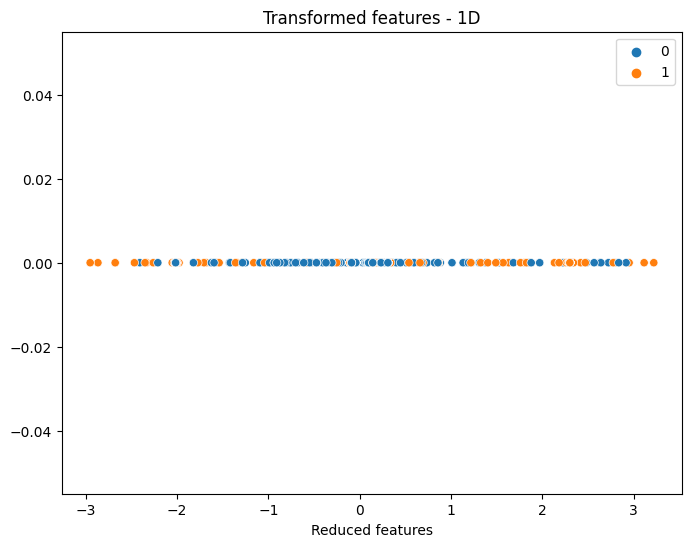

In [9]:
print(X.shape)

# Visualising the DataFrame with the transformed feature and the class labels
tmp_df = pd.DataFrame(X, columns=['Reduced features'])
tmp_df['Label'] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tmp_df, x='Reduced features', y=np.zeros_like(tmp_df['Reduced features']), hue='Label')

plt.legend(loc='upper right')
plt.title('Transformed features - 1D')
plt.show()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#up-sampling minority classes while avoiding overfitting by generating new synthetic examples close to the minority class in feature space.
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)

In [36]:
features = vector.get_feature_names_out()[:50]
print(features)
count = pd.DataFrame(X_train_resampled, columns=tfidf_v.get_feature_names_out())
count.head()

['aaron' 'aaron kesel' 'abandon' 'abc' 'abe' 'abil' 'abl' 'abort' 'abroad'
 'absenc' 'absolut' 'abus' 'academi' 'acc' 'accept' 'access' 'accompani'
 'accomplish' 'accord' 'accord report' 'account' 'accur' 'accus' 'achiev'
 'acknowledg' 'acquir' 'acquisit' 'acr' 'across' 'across countri' 'act'
 'action' 'activ' 'activist' 'activist post' 'actor' 'actress' 'actual'
 'ad' 'adam' 'add' 'add servic' 'add servic site' 'add two' 'add two cent'
 'addict' 'addit' 'address' 'address pleas' 'address pleas reenter']


,aaron,aaron kesel,abandon,abc,abe,abil,abl,abort,abroad,absenc,...,young,younger,your,your robot,your robot click,youth,youtub,zealand,zero,zone
0,0.0,0.0,0.054265,0.0,0.0,0.0,0.017177,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.047125,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
